In [28]:
import json
from queue import PriorityQueue
import sys
import math
import numpy as np
from scipy import interpolate

input = 'adj_ncm1_mr10_lps3.json'
with open(input, 'rb') as fp:
    data = json.load(fp)

adj_data = data['adj']
num_NMC = data['num_NMC']
num_LPS = data['num_LPS']
num_particle = data['num_particle']
vertical_dist_data = data['vertical_dist']
particle_rads_data = data['particle_rads']
particle_type_data = data['type']
SYS_thk = data['thickness']

adj = {}
# count = 0
for key in adj_data.keys():
    bool = False
    value = {}
    # if not adj_data[key].keys() and particle_type_data[key] == 'NMC':
    #     count += 1
    for i in adj_data[key].keys():
        # if adj_data[key][i][2] == 'LPS':
        #     bool = True
        value[int(i)] = adj_data[key][i]
    # if not bool and particle_type_data[key] == 'NMC':
    #     count += 1
    adj[int(key)] = value
# print('count', count)  # number of NMC particles that have no neighbor
# print(adj[404])  # last NMC particle has no neighbor particles!

vertical_dist = {int(key): value for key, value in vertical_dist_data.items()}
particle_rads = {int(key): value for key, value in particle_rads_data.items()}
particle_type = {int(key): value for key, value in particle_type_data.items()}

# Helper function


def heuristic(x):
    if x < 0 or x >= num_particle:
        raise IndexError('Index out of bound.')
    return vertical_dist[x]


def path_finder(s):
    if particle_type[s] != 'NMC':
        raise IndexError('Only consider NMC particles!')

    dist_so_far = [float('inf')] * num_particle
    parent = [None] * num_particle

    pq = PriorityQueue()

    dist_so_far[s] = 0
    source = (heuristic(s), s)
    parent[s] = s

    pq.put(source)
    while not pq.empty():
        _, temp = pq.get()
        if particle_type[temp] == 'Target':
            break
        for v in adj[temp].keys():
            if v == parent[temp] or particle_type[v] == 'NMC':
                continue
            dist = dist_so_far[temp] + adj[temp][v][0]
            if dist < dist_so_far[v]:
                parent[v] = temp
                dist_so_far[v] = dist
                pq.put((dist + heuristic(v), v))

    if not parent[-1]:
        return [], float('inf')

    shortest_path = [num_particle - 1]
    path_length = 0
    particle_on_path = num_particle - 1
    while True:
        v = parent[particle_on_path]
        if v == particle_on_path:
            break
        shortest_path.append(v)
        path_length += adj[v][particle_on_path][0]
        particle_on_path = v
    return list(reversed(shortest_path)), path_length
###

In [41]:
# 1. Define global parameters
pi      = 3.1415926
# Faraday constant, in unit s*A/mol
cn_F    = 96485.3329
# Combined constant: R*T/F, in unit Volt (T is temperature at 298K, F is Faraday constant)
RT_F    = 1/38.87677

# 2. Define parameters for NMC
# Density of NMC, in unit g/cm^3
den_ncm = 4.85
# Molar mass of NMC, in unit g/mol
mss_ncm = 96.95406
# Theoretic Specific capacity for NMC, in unit mAh/g
Qs_max  = cn_F/mss_ncm /3.6

# 3. Define parameters for LPS
# the conductivity of bulk LPS, in unit mS/cm
sgm     = 0.3
# relative conductivity of GB to bulkLPS: lammada_1 = 2*Sgm_bulkLPS*Thickness_GB/Sgm_GBLPS, in unit um
lmd_1   = 0.2

# 4. Define parameters for the interaction between NMC and LPS
# The exchange current density of NMC with LPS, in unit mA/cm^2 
# (this data is from NMC in liqud electrolyte, subject to change)
I_exc   = 1.0

# 5. System parameters
# The current density used in the cell, in unit mA/cm^2
I0      = 0.05
# The area of the model, in unit um^2
A0      = 6400
# Define the timestep, in unit s
dt      = 0.001
# Define the total time want to simulate
T_tot   = 10000.0
# Define output frequency
N_out   = 1000
# The total number of simulation steps
N_tot = int(T_tot/dt)

# 6. Interpolate voltage from voltage-SOC curve got from liquid cell measurement with I0 = 0.01 mA/cm^2
# Read the Li extracted percentage V.S. voltage file
LiX  = []
Vltg = []
fi = open('x_voltage', 'r')
lines = fi.readlines()
for line in lines:
    line = line.rstrip()
    dta = [float(x) for x in line.split()]
    LiX.append(dta[0])
    Vltg.append(dta[1])
# Interpolate according to x-V curve
fxv = interpolate.interp1d(LiX, Vltg)
LiX_max = max(LiX)
LiX_min = min(LiX)
Ucell_max = max(Vltg)

# 7. Variables for internal usage
# Convert Sgm from mS/cm to unit S/um
sgm     = sgm*1e-7
# The total current that path through the model, in unit A
Imdl    = I0*A0*1e-11
# Constant to compute charge-transfer resistance of NMC in LPS, in unit Ohm/um^2
lmd_2   = RT_F / I_exc * 1e11

print(min(Vltg))
print(max(Vltg))

2.030996
4.300006866


In [42]:
# Shortest path
shortest_paths = {}
vol_NMC = 0.
vol_active_NMC = 0.
Om_path = []
vol_nmc_path = []
Omv_tot  = 0.
num_active_NMC = 0

for s in range(num_NMC):
    path, length = path_finder(s)
    vol_NMC += particle_rads[s]**3
    if path:
        vol_active_NMC += particle_rads[s]**3
        shortest_paths[num_active_NMC] = [length, vertical_dist[s],  particle_rads[s], path]
        num_active_NMC += 1
# Compute charge-transfer resistance, resistance from Li+ diffusion in NCM is neglicted 
        R_c   = particle_rads[s]
        tmp1  = adj_data[str(path[0])]
        tmp2  = tmp1[str(path[1])]
        Dlt_c = abs(tmp2[1])
        if len(path) == 2:
            R_Nc = R_c
        else:
            R_N  = particle_rads[path[1]]
            R_Nc = R_c*R_N/(R_c + R_N)
        
        Om_c  = lmd_2/(pi * 2*R_Nc*Dlt_c)
    
# Compute resistance along each path, including LPS bulk resistance R_blk and LPS GB resistance R_gb
        if len(path) == 2:
            Om_b  = 0.
            Om_g  = 0.
        else:
            R_1    = particle_rads[path[-2]]
            R_2    = particle_rads[path[-3]]
            adj1   = adj_data[str(path[-2])]
            tmp    = adj1[str(path[-1])]
            Dlt_01 = abs(tmp[1])
            tmp    = adj1[str(path[-3])]
            Dlt_12 = abs(tmp[1])            
            R_12   = R_1*R_2/(R_1 + R_2)
            cn1    = math.sqrt(1 - 2*Dlt_01/R_1)
            cn2    = math.sqrt(1 - 2*R_12*Dlt_12/(R_1*R_1))
            Om_g   = 1.0/(2*R_1*Dlt_01)
            Om_b   = math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_1           

            if len(path) > 3:
#                print(path)
                for ilps in range(1, len(path)-2):
                  R_i      = particle_rads[path[ilps]]
                  R_im     = particle_rads[path[ilps-1]]
                  R_ip     = particle_rads[path[ilps+1]]
                  adji     = adj_data[str(path[ilps])]
                  tmp      = adji[str(path[ilps-1])]
                  Dlt_im   = abs(tmp[1])
                  tmp      = adji[str(path[ilps+1])]
                  Dlt_ip   = abs(tmp[1])
                  R_imi    = R_im*R_i/(R_im + R_i)
                  R_ipi    = R_ip*R_i/(R_ip + R_i)
                  cn1      = math.sqrt(1 - 2*R_imi*Dlt_im/(R_i*R_i))
                  cn2      = math.sqrt(1 - 2*R_ipi*Dlt_ip/(R_i*R_i))
#                  print([path[ilps],R_i, R_ip, Dlt_ip])
                  Om_g     = Om_g + (1.0/R_i + 1.0/R_ip)/(2*Dlt_ip)
                  Om_b     = Om_b + math.log((1+cn1)/(1-cn1) * (1+cn2)/(1-cn2))/R_i

        Om_g     = lmd_1*Om_g/(2*pi*sgm)
        Om_b     = Om_b/(2*pi*sgm)
        Om_pathi = Om_g + Om_b + Om_c
        Om_path.append(Om_pathi)

        print([Om_g,Om_b,Om_c])

#  Volume of the NMC at current path
        vol_tmp = 4/3.0 * pi * R_c**3
        vol_nmc_path.append(vol_tmp)
        if Om_pathi > 0:
           Omv_tot = Omv_tot + 1.0/Om_pathi

#print(Om_path)
#print(num_active_NMC)

[78205076.06460752, 141434951.0642454, 25711637203.538105]
[577782769.2200167, 570506387.6879082, 69717938170.8766]
[323281203.3174102, 280686410.3661948, 16731675760.595884]
[539728485.7461077, 527819122.1522878, 30133885979.184338]
[620587505.8146074, 444923471.9337383, 18520294985.807785]
[70031482.50030711, 106502080.55294922, 21397861749.443016]
[429287901.203854, 407228684.54628986, 28182007329.791702]
[257617655.91995272, 343201712.21515507, 18498664437.514538]
[709454818.473846, 439389687.2931369, 44206737562.96768]
[735835641.7220445, 558840818.5079304, 59870757369.73287]
[778287934.9793066, 401973044.6415727, 40491140341.412]
[0.0, 0.0, 7854040740.654062]
[170240849.71959734, 192005871.247456, 27290078521.952]
[635229394.3092624, 591328978.8813549, 20659948994.849228]
[38959421.27477411, 69547044.50247426, 23571938250.307907]
[237773643.77515286, 307670455.4463212, 30253150691.215458]
[603002627.5348811, 498908681.87402487, 75143337919.92651]
[227001480.04881537, 204215770.15

[1023099261.136471, 689809250.2672436, 27840365435.67516]
[329222641.82388943, 321333527.8837749, 32778730115.28231]
[517789833.294332, 487614600.9264053, 23056403454.36391]
[1155650943.459768, 559149893.5804329, 36178963024.15736]
[91398972.31096599, 112746489.58739682, 23184136626.89729]
[528455902.1601317, 521733174.26280004, 22006871607.941074]
[212118150.79524228, 200712639.116434, 22315005306.155483]
[506114337.43219185, 485986700.47588634, 31479850587.237606]
[450492852.95910925, 315908960.6499538, 41383616603.18414]
[432416608.3018643, 180056221.2560112, 142333153094.91556]
[618355814.5909376, 605551420.256688, 58340724052.12869]
[624148676.9623134, 534862329.16919804, 21914036594.83386]
[293231905.34888214, 415473581.0976576, 26731417447.084816]
[538954007.5059752, 562699180.9263682, 25326673563.21602]
[350333945.9861934, 315374651.93624353, 37499537414.86981]
[523824570.8673574, 381434487.7384496, 29794338528.58852]
[320567741.56960124, 285293291.95803344, 51345328378.17028]


[202798226.65015188, 199191319.30867797, 20895451972.16588]
[0.0, 0.0, 3528652550.2902336]
[159952437.5348825, 193399697.0298163, 30664296563.74998]
[174820005.43181795, 194636199.94623497, 37149777164.31176]
[442032502.1083176, 411135061.5224348, 28089640572.305264]
[0.0, 0.0, 8198695254.272492]
[572522760.6222242, 500763171.799033, 134100106910.9938]
[192874313.47481492, 226993698.94540685, 15579380991.641666]
[604926762.0289152, 499672746.6857067, 99522897387.62321]
[60132041.45999079, 104753710.13376366, 16533800193.463053]
[461862702.0641601, 437282373.63073856, 23933264758.250275]
[383755160.4513978, 429538502.51213837, 15519910198.658615]
[239187901.87620544, 204139657.85360157, 23811868694.54539]
[417564736.86494446, 404863964.2640992, 24893528223.535034]
[586706975.8781178, 534201065.1115934, 23454281950.14885]
[124406628.11283885, 186072035.25259852, 26409716246.38317]
[34505131.80972348, 67060919.54653199, 19625607540.356945]
[398026163.44936794, 404706177.0799739, 333119651

In [43]:
# The mass of total active NMC particles, in unit g
mdl_mass = 4*pi/3*vol_NMC*den_ncm*1e-12
# Number of active NMC
N_cam     = num_active_NMC
# Get the current passing through each path at each timestep
# The voltage of active CAM particles at each timestep
U_NMC     = np.zeros(N_cam)
# The Li+ content extracted from NMC in Li(1-x)(NMC)
Lix_path  = np.zeros(N_cam)
# The voltage of the cathode composite
#Ucell     = np.array([])
#Ucell     = np.append(Ucell, Imdl/Omv_tot)
#Ucell     = np.zeros(int(N_tot/N_out))
#Ucell[0]  = Imdl/Omv_tot
# The capacity of the cell
#Qcell     = np.zeros(int(N_tot/N_out))
#Qcell     = np.array([])

# Constants used in I-V equation
# Invert resistance of each path and convert to numpy
Om_pv     = 1.0/np.asarray(Om_path, dtype=np.float32)
# Constant 1 in I-V equation
cn1_IV    = Imdl/Omv_tot * Om_pv
# Constant 2 in I-V equation
cn2_IV    = np.tensordot(Om_pv,Om_pv,0)/Omv_tot - np.diag(Om_pv)
# Constant used in x-I equation
vol_nmc_path  = np.asarray(vol_nmc_path, dtype=np.float32)
cn1_xI    = mss_ncm/(den_ncm*vol_nmc_path*cn_F) * 1e12

#print(np.dot(cn2_IV,U_NMC))

In [44]:
idt    = 0.
iout   = 0.
crnt_t = 0.
#crnt_t = 25328.1
#for idt in range(1,N_tot):
while 1 :
  idt = idt + 1
  crnt_t      = crnt_t + dt
# Calculate the current of each path at current timestep
#  Cnt_path = np.zeros(N_cam,1))
  Cnt_path = cn1_IV + np.dot(cn2_IV,U_NMC)
#  print(np.sum(Cnt_path)/Imdl)
# Output the secific capacity (in unit mAh/g) and voltage at current time
  if not idt%N_out :
     iout = iout + 1
#     Qcell[iout] = crnt_t*Imdl/mdl_mass/3.6
#     Ucell[iout] = U_NMC[0] + Om_path[0]*Cnt_path[0]
     Qcell = crnt_t*Imdl/mdl_mass/3.6
     Ucell = U_NMC[0] + Om_path[0]*Cnt_path[0]
     if Ucell > 4.28 :
        dt = 0.01
     elif Ucell > 3.65 :
        dt = 0.1
     elif Ucell > 3.0 :
        dt = 0.008
     elif Ucell > 2.5 :
        dt = 0.005
     elif Ucell > 2.35 :
        dt = 0.001
        
     print([crnt_t, Qcell, Ucell])
#     with open('volt.txt', 'a') as fvlt:
#        fvlt.write('%12.6f %20.16f %20.16f \n'%(crnt_t, Qcell[iout], Ucell[iout]))
    
# Conver the current to change of Li content in Li(1-x)(NMC)
  Lix_path = Lix_path + cn1_xI * Cnt_path * dt
#  print(Cnt_path)

# If any extraction is larger than cutoff Li content, stop the cell
  if max(Lix_path) > LiX_max:
     break

# If not reach the cutoff, continue
# According to the x-V curve, interpolate to get the Voltage of NMC at each Lix
  U_NMC = fxv(Lix_path)   
#  U_NMC = np.interp(Lix_path,LiX,Vltg)  

#  if not idt%5000000 :
#  if not idt%N_out :
#     tmp = 'v_nmc_'+str(int(idt/N_out))
#     np.save(tmp,U_NMC)

#  if not nstep%100:
#    print(nstep)
    


[1.0000000000000007, 0.0025364601154525403, 2.204688254876061]
[1.9999999999998905, 0.0050729202309047995, 2.238175075155217]
[2.9999999999997806, 0.007609380346357059, 2.261942278957779]
[3.9999999999996705, 0.010145840461809318, 2.2813112079178373]
[5.000000000000004, 0.012682300577262705, 2.2979912955624227]
[6.000000000000338, 0.01521876069271609, 2.3128211432755235]
[7.000000000000672, 0.017755220808169478, 2.3262847698967444]
[8.000000000001005, 0.020291680923622858, 2.3387104602966358]
[9.000000000000451, 0.02282814103907399, 2.3503189986455366]
[9.999999999999897, 0.025364601154525122, 2.361172660574342]


KeyboardInterrupt: 

In [382]:
#np.save('v_nmc_100',U_NMC)
#np.save('Lix_100',Lix_path)
#U_NMC1=np.load('v_nmc_1.npy')
#U_NMC2=np.load('v_nmc_2.npy')
#dU = U_NMC1 - U_NMC2
#print(dU)
#with open(str, 'a') as vnmc:
#    vnmc.write('%12.6f \n'%(U_NMC))

[1. 2.]


-0.009000000000000001


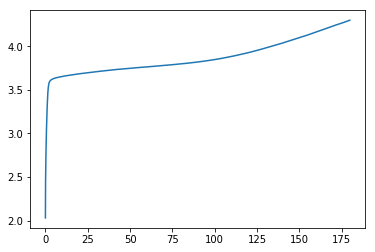

In [226]:
import matplotlib.pyplot as plt

#T_real = N_int*dt_int + (nstep-N_int)*dt
#print(T_real)

LiII = [0 for x in range(len(LiX))]
for i in range(len(LiX)):
  LiII[i]  = LiX[i]*Qs_max
#  print([i,LiII[i],Vltg[i]])

plt.plot(LiII, Vltg, '-')

#plt.plot(Qcell[:nstep], Ucell[:nstep], '-')

with open('ncm_mr25_lps3_I005.txt', 'w') as fout:
    for i in range(len(Qcell[:nstep])):
        fout.write('%s \t %s \n'%(Qcell[i], Ucell[i]))
        
#    for i in range(len(LiII)):
#        fout.write('%s \t %s \n'%(LiII, Vltg))

In [803]:
a=2
b=4
if a==1 and not b%2 :
    print(b)